# ISS PROJEKT 2022/23 <br />
### 18.12.2022 <br />
## Ondřej Lukášek (xlukas15) 

Cílem tohoto projektu bylo vytvořit syntetické piano. Součástí projektu jsou zdrojové kódy a audio soubory. Všechny zdrojové kódy jsou napsány jak v tomto Python Notebooku (zkoušeno na verzi Pythonu 3.8.2), tak v menších Python programech (zkoušeno pro Python verze 3.8.2, 3.10.7 a 3.11.1) a byly využity knihovny jako numpy, scipy, matplotlib, soundfile a IPython a jsou uloženy v souboru xlukas15.tar.gz, ve složce src. Audio soubory jsou ukládány ve formátu .wav a jsou uloženy v souboru xlukas15.tar.gz, ve složce audio.
Výběr midi pro můj login: 40 (82.41 Hz), 76 (659.26 Hz), 105 (3520.00 Hz)

Při vypracování budu používat následující knihovny:

In [69]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.signal as sp

from IPython.display import Audio

## Úloha 4.1

Nyní načteme všechny jednotlivé tóny (respektive celý soubor klavir.waw), jak je napsano v zadání.
Pro načtení jednotlivých tonů použiji návod ze zadání.

In [70]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.35
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
# but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone

Tony pro můj login (xlukas15) jsou 40 (82.41 Hz); 76 (659.26 Hz) a 105 (3520.00 Hz), ty si postupně uložím do souborů, pojmenovaných podle zadání (a_orig.wav, b_orig.wav, c_orig.wav), a uložim je do složky audio.

In [71]:
sf.write('audio/a_orig.wav', xall[40], Fs)
sf.write('audio/b_orig.wav', xall[76], Fs)
sf.write('audio/c_orig.wav', xall[105], Fs)


Jako první je třeba si vykreslit 3 periody pro moje tóny, to se udělá za pomoci mého následujícího kódu.

In [72]:
def periodPrint(fileName, toneFreq):
    s, Fs = sf.read(fileName)
    N = s.size
    period = 1 / toneFreq
    sample = N * period * 3 * 2
    plt.figure(figsize=(10, 3))
    graphTitle = '3 periody', fileName
    plt.title(graphTitle)
    plt.plot(s[:int(sample) + 1])
    plt.show()

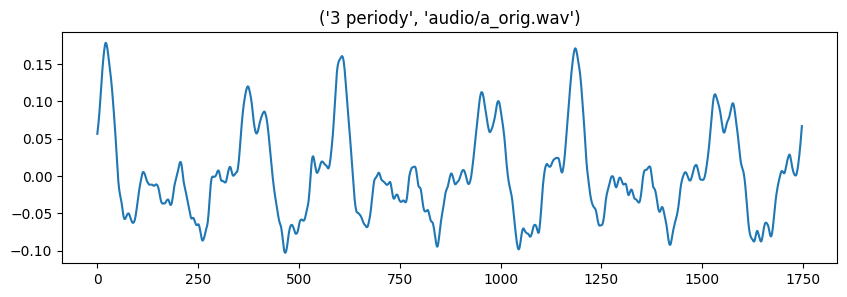

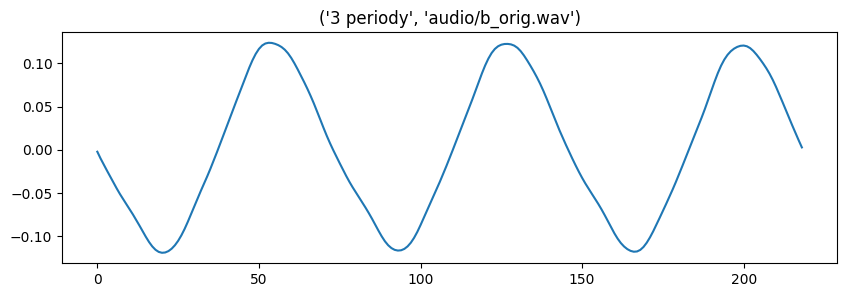

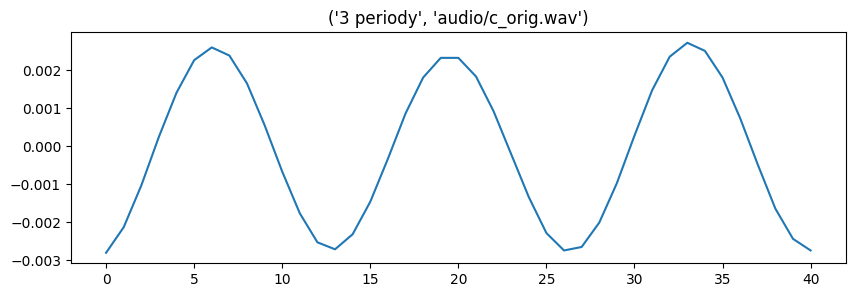

In [73]:
periodPrint('audio/a_orig.wav', 82.41)
periodPrint('audio/b_orig.wav', 659.26)
periodPrint('audio/c_orig.wav', 3520.00)

Nyní je potřeba si vykreslit spektrum pro všechny moje tóny. S tím mi pomohly materiály Kateřiny Žmolíkové, na které je uveden odkaz na stránce předmětu ISS (https://nbviewer.org/github/zmolikova/ISS_project_study_phase/blob/master/Zvuk_spektra_filtrace.ipynb).
Spektrum vytvořím zavoláním mé funkce spectrumPrint().

In [74]:
def spectrumPrint(fileName):
    s, Fs = sf.read(fileName)
    N = s.size
    s_seg_spec = np.fft.fft(s)
    G = 10 * np.log10(1/N * np.abs(s_seg_spec)**2)
    f = np.arange(G.size) / N * Fs

    plt.figure(figsize=(10, 3))
    plt.plot(f[:f.size//2+1], G[:G.size//2+1])
    plt.xlabel('$frekvence [Hz]$')
    graphTitle = 'Spektrum', fileName
    plt.title(graphTitle)

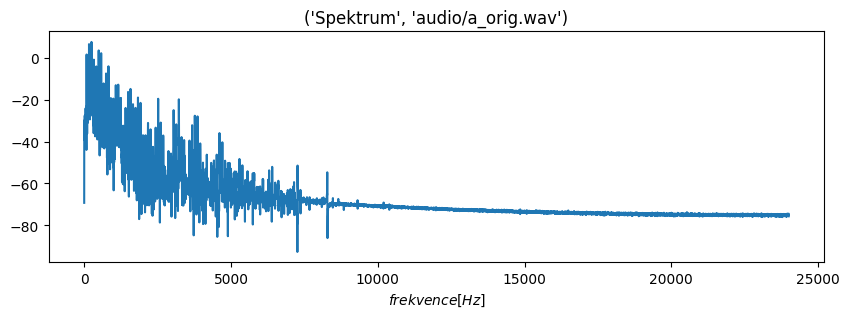

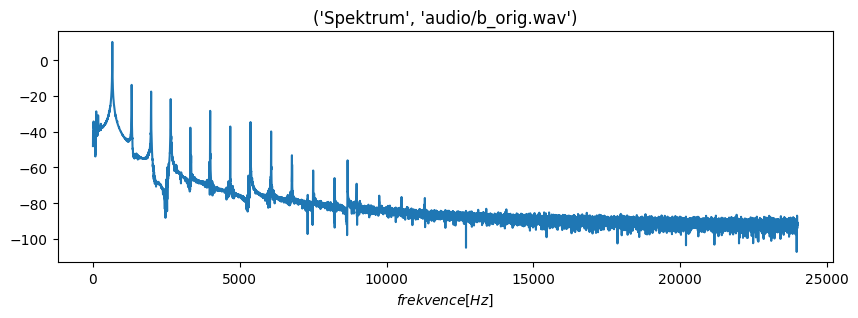

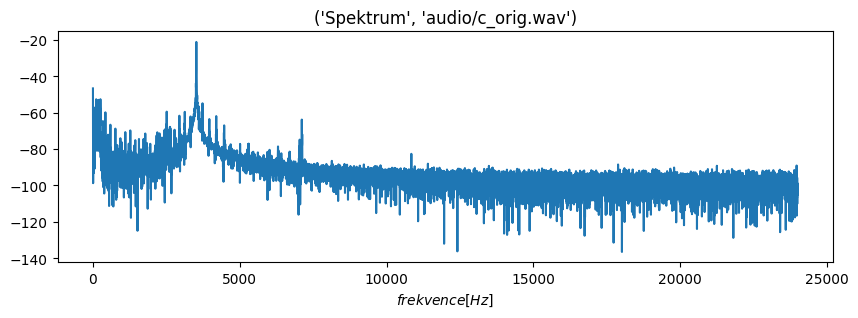

In [75]:
spectrumPrint('audio/a_orig.wav')
spectrumPrint('audio/b_orig.wav')
spectrumPrint('audio/c_orig.wav')

## Úloha 4.2

Nyní mám za úkol určit základní frekvenci u všech tónů. Jelikož by však bylo použití jenom DFT nepřesné (pro nízké tóny), využiji pro nízké tóny autokorelaci. Pro toto zjišťování jsem se inspiroval na stránce Github (https://gist.github.com/endolith/255291/0c0dbc8995bf5c22f56a31036e3094d15bf1b783)
Jelikož následující kousek kódu provádí a vypisuje jak určení základní frekvence pomocí DFT a autokorelace, tak jejich zpřesnění pomocí DTFT, musím upozornit, že pro úlohu 4.2 je potřeba si všímat pouze první frekvence. Tedy pokud je na řádku napsáno "FFT or corelation for midi  24 is:   32.8 Hz   DTFT:   34.1 Hz", zajímá nás pouze první frekvence (32.8 Hz). </br>
Lze si všimnout, že tóny nejsou úplně nejpřesnější, pravděpodobně je to z důvodu, že piano mohlo být lehce rozladěno při nahrávání, Zároveň je výsledek určitě znepřesněn díky DFT, které má tendenci být v nižších frekvencích nepřesné. Kvůli bylo pro nízké frekvence využito autokorelace, ale ani ta není všespásná. Největší rozdíly budou zhruba ve středních tónech (kolem midi 40), kde je užito buď autokorelace nebo DFT a ani jedna z těchto metod nemusí být v daných místech dostatečně přesná.

## Úloha 4.3

Pro vypočtení DTFT jsem naprogramoval funkce makeDTFT a matchDTFT. Vybral jsem si metodu, kde určujeme +-2 koeficienty DFT, protože mi přišla snadnější pro přizpůsobení kódu. </br>
Určitě by bylo vhodné opět zmínit, kde se nechází výpočet DTFT, a je to druhá frekvence výstupu programu. To znamená, že pokud program vypíše "FFT or corelation for midi  24 is:   32.8 Hz   DTFT:   34.1 Hz", zajímá nás druhá frekvence (34.1 Hz).</br>
Je možné si všimnout toho, že tato funkce opět v nízkých frekvencích není úplně přesná. Dle mého názoru je to z důvodu, že byť se jedná o něco přesnější formu DFT, stále se o DFT jedná, a to není na nízké frekvence přesné. Moji myšlenku posiluje fakt, že ve vyšších tónech (stejně jako u DFT) dochází k zlepšení přesnosti výpočtu frekvence. Některé nuance mohou být opět způsobeny lehce rozladěným klavírem. Lepším výsledkům by také napomohla větší vzorkovací frekvence, při které by se přesnost DTFT opět o něco málo zvýšila.

In [76]:
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

def makeDTFT(s, fs, freq):
    N = s.size
    sampleTime = float(N) / fs
    x = np.linspace(0, freq * sampleTime * 2 * np.pi, num = 24000)
    ySin = np.sin(x)
    yCos = np.cos(x)
    im = np.dot(s, ySin)
    re = np.dot(s, yCos)
    return complex(re, im)

def matchDTFT(s, fs, rawFreq, sweep):
    maxVal = 0
    exactFreq = rawFreq
    for i in range(int(sweep * 2 * 10)):
        freq = rawFreq - float(sweep) + float(i) / 10.0
        res = np.abs(makeDTFT(s, fs, freq))
        if res > maxVal:
            maxVal = res
            exactFreq = freq
    return exactFreq

MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.35
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
# but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
midiNumber = 24
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
    # misto 's' ted pracujeme s 'x'
    N = x.size
    if midiNumber < 47:
        # Calculate autocorrelation and throw away the negative lags
        corr = sp.fftconvolve(x, x[::-1], mode='full')
        corr = corr[int(len(corr)/2):]

        # Find the first low point
        d = np.diff(corr)
        start = find(d > 0)[0]

        # Find the next peak after the low point (other than 0 lag).  This bit is 
        # not reliable, due to peaks that occur between samples.
        peak = np.argmax(corr[start:]) + start
        freq = Fs / peak
    else:
        sSegSpec = np.fft.fft(x)
        i = np.argmax(abs(np.split(sSegSpec, 2)[0]))
        freq = Fs * i / N 
    print('FFT or corelation for midi', '{:>3}'.format(midiNumber), 'is:', '{:>6}'.format(round(freq, 1)), "Hz", "  DTFT:", '{:>6}'.format(round(matchDTFT(x, Fs, freq, 4), 1)), "Hz")
    midiNumber = midiNumber + 1

FFT or corelation for midi  24 is:   32.8 Hz   DTFT:   34.1 Hz
FFT or corelation for midi  25 is:   34.8 Hz   DTFT:   34.0 Hz
FFT or corelation for midi  26 is:   36.8 Hz   DTFT:   36.3 Hz
FFT or corelation for midi  27 is:   39.0 Hz   DTFT:   41.0 Hz
FFT or corelation for midi  28 is:   41.3 Hz   DTFT:   45.1 Hz
FFT or corelation for midi  29 is:   43.8 Hz   DTFT:   42.2 Hz
FFT or corelation for midi  30 is:   46.4 Hz   DTFT:   45.6 Hz
FFT or corelation for midi  31 is:   49.2 Hz   DTFT:   46.9 Hz
FFT or corelation for midi  32 is:   52.1 Hz   DTFT:   54.4 Hz
FFT or corelation for midi  33 is:   55.2 Hz   DTFT:   56.6 Hz
FFT or corelation for midi  34 is:   58.5 Hz   DTFT:   59.4 Hz
FFT or corelation for midi  35 is:   61.9 Hz   DTFT:   61.8 Hz
FFT or corelation for midi  36 is:   65.6 Hz   DTFT:   65.1 Hz
FFT or corelation for midi  37 is:   69.5 Hz   DTFT:   68.1 Hz
FFT or corelation for midi  38 is:   73.5 Hz   DTFT:   73.0 Hz
FFT or corelation for midi  39 is:   77.9 Hz   DTFT:   

## Úloha 4.4

10 floating point čísel

In [77]:
def pianoRepre(fileName):
    s, fs = sf.read(fileName)
    N = s.size

    sSegSpec = np.fft.fft(s)
    G = 10 * np.log10(1/N * np.abs(sSegSpec)**2 + 10e-5)
    f = np.arange(G.size) / N * fs

    i = np.argmax(abs(np.split(sSegSpec, 2)[0]))
    rawFreq = fs * i / N 

    f0 = matchDTFT(s, fs, rawFreq, 4)

    multFreqs = range(1, 11)
    freqs = multFreqs * f0
    print(freqs)
    accFreqs = np.zeros(10, dtype = float)
    resDTFT = np.zeros(10, dtype = complex)
    for i in range(10):
        accFreqs[i] = matchDTFT(s, fs, freqs[i], 4) # doladujeme na +-2 koeficienty DFT, coz zpusobuje nepresnost pri "nasobeni chyby dft"
        resDTFT[i] = makeDTFT(s, fs, accFreqs[i])
        
    print(accFreqs)
    resMod = np.zeros(10, dtype = float)
    resPhase = np.zeros(10, dtype = float)
    for i in range(10):
        tmpRes = resDTFT[i]
        resMod[i] = np.abs(tmpRes)
        resPhase[i] = np.angle(tmpRes)
    for i in range(10):
        print("Frekvence", '{:>8.1f}'.format(accFreqs[i]), "Hz", "   Modul:", '{:>7.2f}'.format(round(resMod[i],2)), "   Faze:", '{:>7.2f}'.format(round(resPhase[i],2)))


    plt.figure(figsize=(15,5))
    plt.plot(f[:f.size//2+1], G[:G.size//2+1])
    plt.xlabel('$f[Hz]$')
    plt.grid(alpha=0.5, linestyle='--')
    graphTitle = "Reprezentace klaviru pro", fileName
    plt.title(graphTitle)

    for i in range(10):
        y = 10 * np.log10(1/N * np.abs(resMod[i])**2 + 10e-5)
        plt.plot(accFreqs[i], y, 'x')

    plt.show()

[ 247.1  494.2  741.3  988.4 1235.5 1482.6 1729.7 1976.8 2223.9 2471. ]
[ 247.1  494.4  743.   992.3 1238.2 1485.2 1731.3 1973.1 2225.5 2470.5]
Frekvence    247.1 Hz    Modul:  512.25    Faze:   -0.06
Frekvence    494.4 Hz    Modul:  245.85    Faze:    1.36
Frekvence    743.0 Hz    Modul:   92.55    Faze:    3.00
Frekvence    992.3 Hz    Modul:   17.18    Faze:   -2.81
Frekvence   1238.2 Hz    Modul:    7.65    Faze:    2.34
Frekvence   1485.2 Hz    Modul:    2.49    Faze:    2.03
Frekvence   1731.3 Hz    Modul:    0.99    Faze:    0.76
Frekvence   1973.1 Hz    Modul:    0.51    Faze:   -2.32
Frekvence   2225.5 Hz    Modul:    0.26    Faze:    0.73
Frekvence   2470.5 Hz    Modul:    0.37    Faze:   -2.64


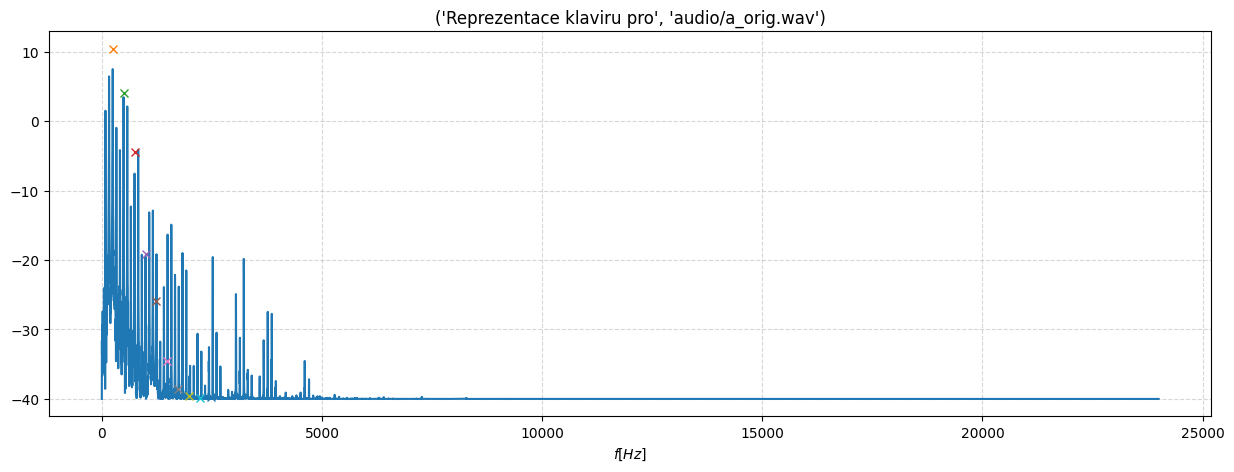

[ 659.1 1318.2 1977.3 2636.4 3295.5 3954.6 4613.7 5272.8 5931.9 6591. ]
[ 659.1 1317.9 1981.2 2640.3 3294.9 3955.3 4616.  5268.8 5930.2 6592.2]
Frekvence    659.1 Hz    Modul:  697.37    Faze:   -1.48
Frekvence   1317.9 Hz    Modul:   31.81    Faze:    1.62
Frekvence   1981.2 Hz    Modul:   15.74    Faze:    1.43
Frekvence   2640.3 Hz    Modul:    1.87    Faze:    2.86
Frekvence   3294.9 Hz    Modul:    0.10    Faze:    0.41
Frekvence   3955.3 Hz    Modul:    0.12    Faze:   -0.81
Frekvence   4616.0 Hz    Modul:    0.06    Faze:   -0.98
Frekvence   5268.8 Hz    Modul:    0.05    Faze:    1.22
Frekvence   5930.2 Hz    Modul:    0.03    Faze:    0.03
Frekvence   6592.2 Hz    Modul:    0.03    Faze:   -0.45


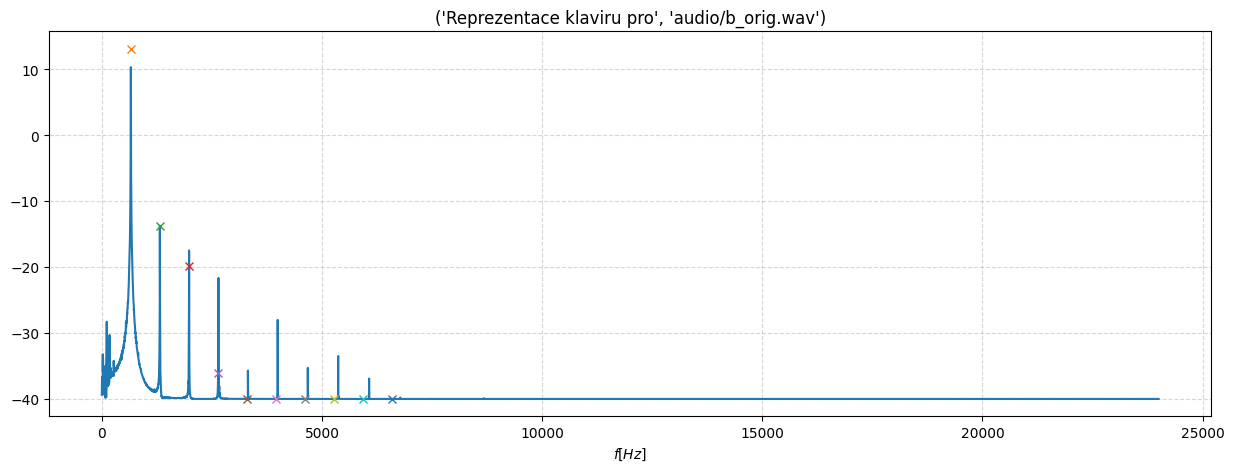

[ 3521.5  7043.  10564.5 14086.  17607.5 21129.  24650.5 28172.  31693.5
 35215. ]
[ 3521.5  7042.1 10565.8 14085.4 17611.4 21128.5 24652.1 28175.9 31695.7
 35212.3]
Frekvence   3521.5 Hz    Modul:   14.20    Faze:    2.58
Frekvence   7042.1 Hz    Modul:    0.03    Faze:   -2.15
Frekvence  10565.8 Hz    Modul:    0.00    Faze:   -2.71
Frekvence  14085.4 Hz    Modul:    0.00    Faze:   -2.64
Frekvence  17611.4 Hz    Modul:    0.00    Faze:   -2.90
Frekvence  21128.5 Hz    Modul:    0.00    Faze:   -3.00
Frekvence  24652.1 Hz    Modul:    0.00    Faze:   -3.10
Frekvence  28175.9 Hz    Modul:    0.00    Faze:    2.84
Frekvence  31695.7 Hz    Modul:    0.00    Faze:    2.28
Frekvence  35212.3 Hz    Modul:    0.00    Faze:    2.72


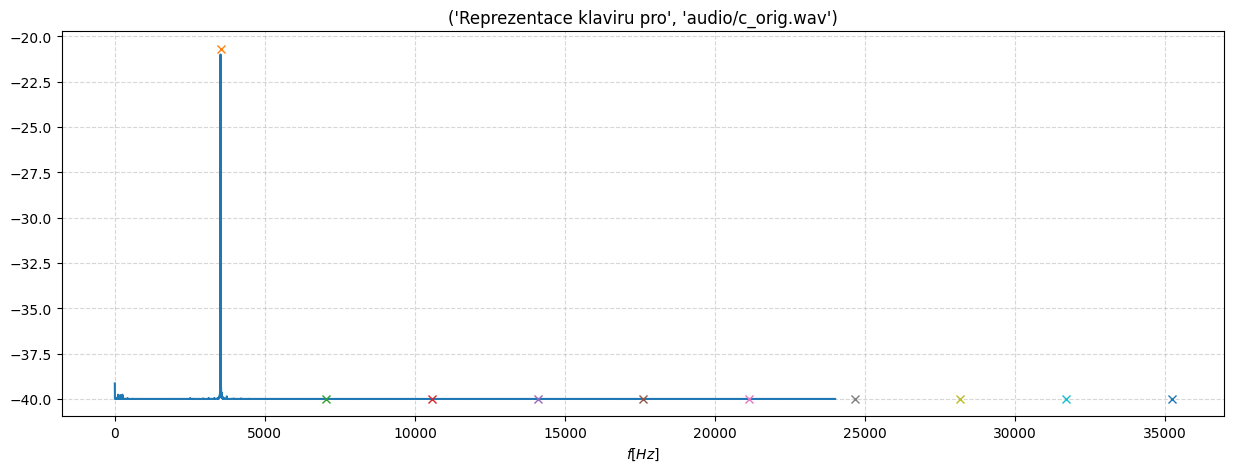

In [78]:
pianoRepre("audio/a_orig.wav")
pianoRepre("audio/b_orig.wav")
pianoRepre("audio/c_orig.wav")

## Úloha 4.5

Syntéza tónů